# **4 Different Features version**

## **Imports**

In [ ]:
import pandas as pd
from random import randint
import numpy as np

## **Data**

In [ ]:
data = pd.read_csv('CRYPTOCURRENCY_COINDESK_BTCUSD_NEW.csv')

## **Generating Day, Month, Year features from Date**

Four different feature were created from 'Date' Column.
Year, Month, Day and Day number which shows the index of current day in the data.

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

In [ ]:
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day

In [ ]:
data['year'] = data['year'] % 2020 + 1

In [ ]:
data['day_number'] = data.index.values + 1

## **Data Cleaning**

In [ ]:
data['Close'] = data['Close'].apply(lambda s: s.replace(',', ''))
data['Close'] = data['Close'].astype('float32')

## **Adding Polynomial Features**

10 different degree of polynomial!

In [ ]:
fn = ['day_number', 'year', 'month', 'day']
an = ['day_number', 'year', 'month', 'day', 'Close']
powers = 10

for i in range(2, powers+1):
  data['y'+str(i)] = data['year'] ** i
  data['m'+str(i)] = data['month'] ** i
  data['d'+str(i)] = data['day'] ** i
  
  fn.append('y'+str(i))
  fn.append('m'+str(i))
  fn.append('d'+str(i))

  an.append('y'+str(i))
  an.append('m'+str(i))
  an.append('d'+str(i))
  
an.append('Close')

In [ ]:
data

,Date,Close,year,month,day,day_number,y2,m2,d2,y3,m3,d3,y4,m4,d4,y5,m5,d5,y6,m6,d6,y7,m7,d7,y8,m8,d8,y9,m9,d9,y10,m10,d10
0,2020-10-11,11350.0,1,10,11,1,1,100,121,1,1000,1331,1,10000,14641,1,100000,161051,1,1000000,1771561,1,10000000,19487171,1,100000000,214358881,1,1000000000,2357947691,1,10000000000,25937424601
1,2020-10-12,11564.0,1,10,12,2,1,100,144,1,1000,1728,1,10000,20736,1,100000,248832,1,1000000,2985984,1,10000000,35831808,1,100000000,429981696,1,1000000000,5159780352,1,10000000000,61917364224
2,2020-10-13,11437.0,1,10,13,3,1,100,169,1,1000,2197,1,10000,28561,1,100000,371293,1,1000000,4826809,1,10000000,62748517,1,100000000,815730721,1,1000000000,10604499373,1,10000000000,137858491849
3,2020-10-14,11396.0,1,10,14,4,1,100,196,1,1000,2744,1,10000,38416,1,100000,537824,1,1000000,7529536,1,10000000,105413504,1,100000000,1475789056,1,1000000000,20661046784,1,10000000000,289254654976
4,2020-10-15,11544.0,1,10,15,5,1,100,225,1,1000,3375,1,10000,50625,1,100000,759375,1,1000000,11390625,1,10000000,170859375,1,100000000,2562890625,1,1000000000,38443359375,1,10000000000,576650390625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2021-10-07,54205.0,2,10,7,362,4,100,49,8,1000,343,16,10000,2401,32,100000,16807,64,1000000,117649,128,10000000,823543,256,100000000,5764801,512,1000000000,40353607,1024,10000000000,282475249
362,2021-10-08,53951.0,2,10,8,363,4,100,64,8,1000,512,16,10000,4096,32,100000,32768,64,1000000,262144,128,10000000,2097152,256,100000000,16777216,512,1000000000,134217728,1024,10000000000,1073741824
363,2021-10-09,54651.0,2,10,9,364,4,100,81,8,1000,729,16,10000,6561,32,100000,59049,64,1000000,531441,128,10000000,4782969,256,100000000,43046721,512,1000000000,387420489,1024,10000000000,3486784401
364,2021-10-10,55425.0,2,10,10,365,4,100,100,8,1000,1000,16,10000,10000,32,100000,100000,64,1000000,1000000,128,10000000,10000000,256,100000000,100000000,512,1000000000,1000000000,1024,10000000000,10000000000


## **Normalizing the data**

In [ ]:
max_v = np.amax(np.array(data[an].values), axis=0)
min_v = np.amin(np.array(data[an].values), axis=0)
mean_v = np.mean(np.array(data[an].values), axis=0)

In [ ]:
def normalize(X):
  return (X - np.mean(X, axis=0)) / (np.amax(X, axis=0) - np.amin(X, axis=0))

In [ ]:
data[an] = normalize(np.array(data[an].values))

In [ ]:
data

,Date,Close,year,month,day,day_number,y2,m2,d2,y3,m3,d3,y4,m4,d4,y5,m5,d5,y6,m6,d6,y7,m7,d7,y8,m8,d8,y9,m9,d9,y10,m10,d10
0,2020-10-11,-0.525500,-0.775956,0.314953,-0.156922,-0.500000,-0.775956,0.317475,-0.211410,-0.775956,0.282811,-0.207833,-0.775956,0.235972,-0.186065,-0.775956,0.188609,-0.162685,-0.775956,0.145067,-0.142394,-0.775956,0.10669,-0.125807,-0.775956,0.073614,-0.112414,-0.775956,0.045488,-0.101542,-0.775956,0.021783,-0.092610
1,2020-10-12,-0.521389,-0.775956,0.314953,-0.123588,-0.497260,-0.775956,0.317475,-0.187452,-0.775956,0.282811,-0.194506,-0.775956,0.235972,-0.179465,-0.775956,0.188609,-0.159619,-0.775956,0.145067,-0.141025,-0.775956,0.10669,-0.125213,-0.775956,0.073614,-0.112162,-0.775956,0.045488,-0.101436,-0.775956,0.021783,-0.092566
2,2020-10-13,-0.523829,-0.775956,0.314953,-0.090255,-0.494521,-0.775956,0.317475,-0.161410,-0.775956,0.282811,-0.178763,-0.775956,0.235972,-0.170992,-0.775956,0.188609,-0.155341,-0.775956,0.145067,-0.138951,-0.775956,0.10669,-0.124234,-0.775956,0.073614,-0.111709,-0.775956,0.045488,-0.101230,-0.775956,0.021783,-0.092473
3,2020-10-14,-0.524616,-0.775956,0.314953,-0.056922,-0.491781,-0.775956,0.317475,-0.133285,-0.775956,0.282811,-0.160401,-0.775956,0.235972,-0.160321,-0.775956,0.188609,-0.149525,-0.775956,0.145067,-0.135906,-0.775956,0.10669,-0.122684,-0.775956,0.073614,-0.110935,-0.775956,0.045488,-0.100850,-0.775956,0.021783,-0.092288
4,2020-10-15,-0.521774,-0.775956,0.314953,-0.023588,-0.489041,-0.775956,0.317475,-0.103077,-0.775956,0.282811,-0.139219,-0.775956,0.235972,-0.147101,-0.775956,0.188609,-0.141786,-0.775956,0.145067,-0.131555,-0.775956,0.10669,-0.120305,-0.775956,0.073614,-0.109661,-0.775956,0.045488,-0.100177,-0.775956,0.021783,-0.091938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2021-10-07,0.297575,0.224044,0.314953,-0.290255,0.489041,0.224044,0.317475,-0.286410,0.224044,0.282811,-0.240999,0.224044,0.235972,-0.199318,0.224044,0.188609,-0.167723,0.224044,0.145067,-0.144257,0.224044,0.10669,-0.126485,0.224044,0.073614,-0.112659,0.224044,0.045488,-0.101630,0.224044,0.021783,-0.092641
362,2021-10-08,0.292696,0.224044,0.314953,-0.256922,0.491781,0.224044,0.317475,-0.270785,0.224044,0.282811,-0.235326,0.224044,0.235972,-0.197483,0.224044,0.188609,-0.167166,0.224044,0.145067,-0.144095,0.224044,0.10669,-0.126439,0.224044,0.073614,-0.112646,0.224044,0.045488,-0.101626,0.224044,0.021783,-0.092640
363,2021-10-09,0.306140,0.224044,0.314953,-0.223588,0.494521,0.224044,0.317475,-0.253077,0.224044,0.282811,-0.228041,0.224044,0.235972,-0.194814,0.224044,0.188609,-0.166248,0.224044,0.145067,-0.143791,0.224044,0.10669,-0.126341,0.224044,0.073614,-0.112615,0.224044,0.045488,-0.101616,0.224044,0.021783,-0.092637
364,2021-10-10,0.321006,0.224044,0.314953,-0.190255,0.497260,0.224044,0.317475,-0.233285,0.224044,0.282811,-0.218944,0.224044,0.235972,-0.191090,0.224044,0.188609,-0.164818,0.224044,0.145067,-0.143263,0.224044,0.10669,-0.126152,0.224044,0.073614,-0.112549,0.224044,0.045488,-0.101593,0.224044,0.021783,-0.092629


## **Splitting the data**

Here, I splited the data in two part(train, val).
First of all, the cength of each part were calculated, then while the length of list of selected indexes is not equal to length of validation part, the while continues, when the lengths are equal, i took the every parts by their indexes!

In [ ]:
def train_val_split(data, p):
  length = len(data)
  t_l = int(length * p)

  l = []
  while len(l) != length - t_l:
    t = randint(0, length-1)
    if t not in l:
      l.append(t)

  X_val =  data.loc[l]
  y_val = data.loc[l]  
  X_val =  X_val[fn]
  y_val = y_val[['Close']]


  X_train = data.drop(l)
  y_train = data.drop(l)
  X_train = X_train[fn]
  y_train = y_train[['Close']]
  return X_train, y_train, X_val, y_val

In [ ]:
X_train, y_train, X_valid, y_valid = train_val_split(data, 0.8)

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid =  np.array(X_valid)
y_valid = np.array(y_valid)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(292, 31)
(292, 1)
(74, 31)
(74, 1)


## **Model**

In [ ]:
def cost_function(y, p):
  m = len(y)
  cost = (1 / m) * np.sum(np.multiply((y - p),(y - p)))
  return cost

In [ ]:
def calc_derivative(X, y, p):
  w_d = (-2 / len(X)) * np.dot(X.transpose(), (y - p))
  b_d = (-2 / len(X)) * np.sum((y - p))
  return w_d, b_d

In [ ]:
def predict(X, W, b):
  return np.dot(X, W) + b

In [ ]:
def gradient_descent(X, y, X_valid, y_valid, n_itrs = 15000, alpha = 0.001):
  # W = np.zeros((X.shape[1], 1))
  # b = 1
  W = np.random.random_sample((X.shape[1], 1))
  b = np.random.random_sample((1, 1))
  valid_costs = []
  costs = []
  derivatives = []
  for i in range(n_itrs):
    p = predict(X, W, b)

    cost = cost_function(y, p)
    costs.append(cost)

    v_c = cost_function(y_valid, predict(X_valid, W, b))
    valid_costs.append(v_c)
      
    derv_w, derv_b = calc_derivative(X, y, p)
    derivatives.append([derv_w, derv_b])

    W -= alpha * derv_w
    b -= alpha * derv_b
    
  return W, b, costs, derivatives

## **Trying the model for ten different degrees**

In [ ]:
costs = []
Ws = []
bs = []
mc = 10
i_a = -1

for i in range(powers):
  
  W, b, costs_i, derivatives = gradient_descent(X_train[:, :3 * (i + 1) +1], y_train, X_valid[:, :3 * (i + 1) +1], y_valid, n_itrs = 1000000 + 10000 * i)
  p = predict(X_valid[:, :3 * (i + 1) +1], W, b)
  c = cost_function(y_valid, p)
  if c < mc:
    mc = c
    Ws=W
    bs = b
    i_a = i
  print(i, ' : ',c)

0  :  0.025724637949798918
1  :  0.025612433595704868
2  :  0.022936415669287554
3  :  0.02121698248032308
4  :  0.02163950907703481
5  :  0.0221802798014713
6  :  0.021829519142747725
7  :  0.021168194308887597
8  :  0.02044185232984919
9  :  0.01950113522883383


In [ ]:
p = predict(X_train[:, :3 * (i_a + 1) +1], Ws, bs)

Comparing the actual and predicted values.

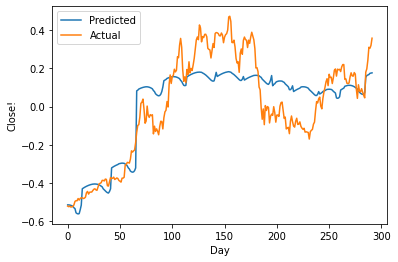

In [ ]:
import matplotlib.pyplot as plt

plt.plot(p, label= 'Predicted')
plt.plot(y_train, label= 'Actual')
plt.legend(loc='best')
plt.xlabel('Day')
plt.ylabel('Close!')
plt.show()